## Decision gradient

DeviceArray(0., dtype=float32, weak_type=True)

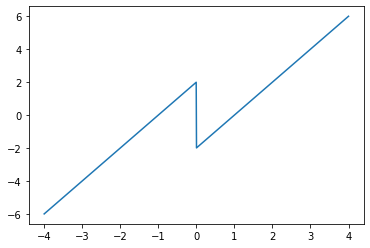

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as rd
import numpy as np

def f(x):
    return jnp.minimum((x-1)**2, (x+1)**2)

x = jnp.linspace(-4,4,1000)
y = jax.vmap(jax.grad(f))(x)
plt.plot(x,y)

def f1(theta, y, x):
    return 0.5*jnp.abs(y*jnp.exp(1j*theta) - x)**2

def g1(theta, y, x):
    return jnp.imag(jnp.conj(x)* y * jnp.exp(1j*theta))

x = 1.0 + 1j
y = 3 + 4j

jax.grad(f1)(1.0, y,x) - g1(1.0,y,x)

## np.unwrap

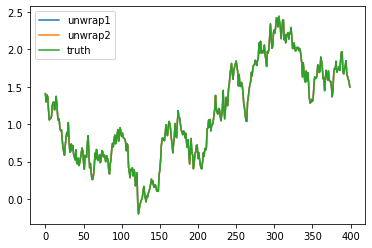

In [6]:
n1 = rd.normal(rd.PRNGKey(1), (400,))*0.1
theta =jnp.cumsum(n1) + jnp.pi/2
phi = theta % (jnp.pi/2)

theta1 = jnp.unwrap(phi,period=jnp.pi/2)
theta2 = jnp.unwrap(4*phi) / 4

plt.plot(theta1, label='unwrap1')
plt.plot(theta2, label='unwrap2')
plt.plot(theta, label='truth')
plt.legend()

## DDPLL

In [6]:
import jax, jax.numpy as jnp, matplotlib.pyplot as plt, jax.random as rd,numpy as np
from optical_flax.dsp import cpr, bps, ddpll
from optical_flax.fiber_tx import QAM
from optical_flax.fiber_system import Tx_data
from optical_flax.utils import show_symb
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.30'
from jax.config import config
config.update("jax_enable_x64", False)


## Step 1: data
M = 16
mod = QAM(M)
constSymb = mod.constellation / jnp.sqrt(mod.Es)
sigWDM, symbWDM, param = Tx_data(rd.PRNGKey(0), 1, Nmodes=1, Power=0,Nch=3, SpS=32, Nbits=int(np.log2(M))*4000, Rs=190e9, freq_space=220e9, M=M)
truth = jax.device_get(symbWDM[:,0,:])
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.02
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.1
pn = jnp.cumsum(n1, axis=0)
y = truth * jnp.exp(1j*pn) + n2


Sample rate fa: 6.08e+12, Cut off frequency fc: 3.3e+11, fa > 2fc: True
Transmitter is working..
signal shape: (128000, 1), symb shape: (4000, 3, 1)
 Tx_data complete, time cost(s):0.6845827102661133


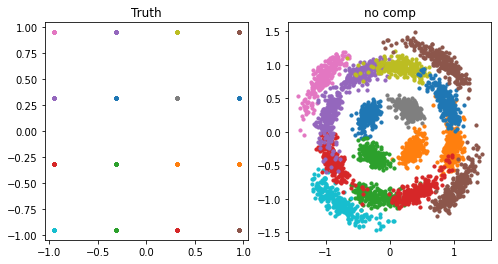

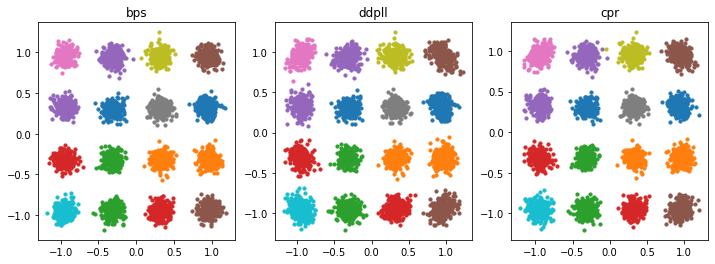

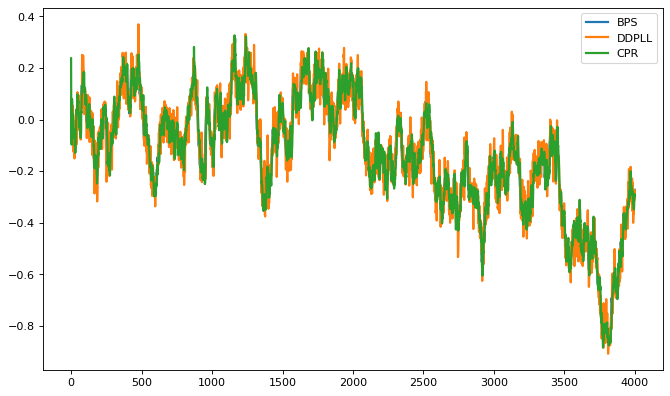

In [3]:

## Step 2: Adaptive filter
## BPS
y_rec = {}
theta = {}
y_rec['bps'], theta['bps'] = bps(jax.device_get(y),5, jax.device_get(constSymb), 101)

## DDPLL
tau1 = 1 / (2 * np.pi * 10e6)
tau2 = 1 / (2 * np.pi * 10e6)
y_rec['ddpll'], theta['ddpll'] = ddpll(jax.device_get(y), 0.5, constSymb, truth)


## CPR
y_rec['cpr'], theta['cpr'] = cpr(jax.device_get(y), 7, jax.device_get(constSymb), jax.device_get(truth))



## Step 3: show symbol

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
show_symb(truth[:,0], jax.device_get(truth[:,0]))
plt.title('Truth')
plt.subplot(1,2,2)
plt.title('no comp')
show_symb(y[:,0], jax.device_get(truth[:,0]))


rec = ['bps','ddpll','cpr']
plt.figure(figsize=(12,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    show_symb(y_rec[rec[i-1]][:,0], jax.device_get(truth[:,0]))
    plt.title(rec[i-1])

plt.figure(figsize=(10,6),dpi=80)
plt.plot(theta['bps'][0:10000], label='BPS',linewidth=2)
plt.plot(theta['ddpll'][0:10000], label='DDPLL',linewidth=2)
plt.plot(theta['cpr'][0:10000], label='CPR',linewidth=2)
plt.legend()

## OPT_Cell and meta learning

In [5]:
import flax.linen as nn 
from typing import Any
import optax
import warnings
warnings.filterwarnings("ignore")

def sigmoid_init(key, lr):
    return -jnp.log(1. / lr - 1)



class OPT_cell(nn.Module):
    opt:Any=optax.inject_hyperparams(optax.adam)(learning_rate=0.1)
    init_lr:float=0.01

    def f(self, theta,x):
        return theta*x

    def loss(self, theta, x, y):
        y_hat = self.f(theta, x)
        return jnp.mean((y - y_hat)**2)/2, y_hat
    

    @nn.compact
    def __call__(self, h, inputs):
        theta,state = h
        x,y = inputs
        eta = self.param('eta', sigmoid_init, self.init_lr)
        bf_b1 = self.param('b1', sigmoid_init, 0.9)
        bf_b2 = self.param('b2', sigmoid_init, 0.999)
        state.hyperparams['learning_rate'] = jax.nn.sigmoid(eta)
        state.hyperparams['b1'] = jax.nn.sigmoid(bf_b1)
        state.hyperparams['b2'] = jax.nn.sigmoid(bf_b2)
        grads,y_hat = jax.grad(self.loss, has_aux=True)(theta, x, y)
        updates, state = self.opt.update(grads, state)
        theta = optax.apply_updates(theta, updates)
        return (theta, state),  y_hat

    
    def initialize_carry(self):
        theta = jnp.ones(1)
        state = self.opt.init(theta)
        return theta, state

   
x = rd.normal(rd.PRNGKey(1), (10,1))
y = 10*x + rd.normal(rd.PRNGKey(2), (10,1))*0.1

In [10]:
PE = nn.scan(OPT_cell, variable_broadcast="params",split_rngs={'params':False}, in_axes=0, out_axes=0)
h = OPT_cell() .initialize_carry() # theta, state
OPT = PE()
param = OPT.init(rd.PRNGKey(1), h,(x,y))

meta_opt = optax.adam(learning_rate=0.05)
meta_state = meta_opt.init(param)

def outer_loss(param,h,OPT):
    h, y_hat = OPT.apply(param, h, (x,y))
    return jnp.mean((y - y_hat)**2), h

@jax.jit
def outer_loop(state, xs):
    param, h, meta_state = state
    (l,h), grads = jax.value_and_grad(outer_loss, has_aux=True)(param, h, OPT)
    updates,meta_state = meta_opt.update(grads, meta_state)
    param = optax.apply_updates(param, updates)
    return (param, h, meta_state), (param, h[0],l)

(param, h, meta_state), (history,theta,l) = jax.lax.scan(outer_loop, (param, h, meta_state), jnp.ones(1000))

Text(0.5, 1.0, 'b2')

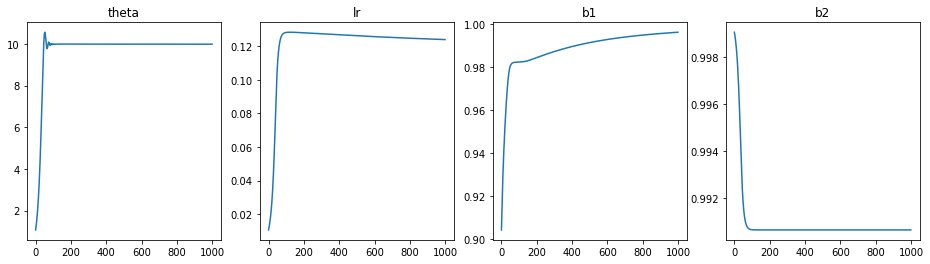

In [11]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.title('theta')
plt.plot(theta)
plt.subplot(1,4,2)
plt.plot(jax.nn.sigmoid(history['params']['eta']))
plt.title('lr')
plt.subplot(1,4,3)
plt.plot(jax.nn.sigmoid(history['params']['b1']))
plt.title('b1')
plt.subplot(1,4,4)
plt.plot(jax.nn.sigmoid(history['params']['b2']))
plt.title('b2')

## DDPLL

In [7]:
## Step 1: data
M = 16
mod = QAM(M)
constSymb = mod.constellation / jnp.sqrt(mod.Es)
sigWDM, symbWDM, param = Tx_data(rd.PRNGKey(0), 1, Nmodes=1, Power=0,Nch=3, SpS=32, Nbits=int(np.log2(M))*40000, Rs=190e9, freq_space=220e9, M=M)
truth = jax.device_get(symbWDM[:,0,:])
n1 = rd.normal(rd.PRNGKey(0), truth.shape, dtype=jnp.float64)*0.04
n2 = rd.normal(rd.PRNGKey(1), truth.shape, dtype=jnp.complex128)*0.1
pn = jnp.cumsum(n1, axis=0)
y = truth * jnp.exp(1j*pn) + n2


from optical_flax.operator import frame
xs = frame(y, 20, 20)
ys = frame(truth, 20,20)
dataset = (xs,ys)

Sample rate fa: 6.08e+12, Cut off frequency fc: 3.3e+11, fa > 2fc: True
Transmitter is working..
signal shape: (1280000, 1), symb shape: (40000, 3, 1)
 Tx_data complete, time cost(s):1.072204351425171


In [8]:
class PE_cell(nn.Module):
    opt:Any=optax.inject_hyperparams(optax.sgd)(learning_rate=0.5, momentum=0.1)
    init_lr:float=0.1
    init_momentum:float=0.1

    def f(self, theta, x):
        # Phase rotation
        return jnp.exp(1j*theta)*x

    def loss(self, theta, x):
        # MSE
        y_hat = self.f(theta, x)
        return jnp.min(jnp.abs(constSymb - y_hat)**2), y_hat
    

    @nn.compact
    def __call__(self, h, x):
        theta,state = h
        eta = self.param('eta', sigmoid_init, self.init_lr)
        m = self.param('momentum', sigmoid_init, self.init_momentum)
        state.hyperparams['learning_rate'] = jax.nn.sigmoid(eta)
        state.hyperparams['momentum'] = jax.nn.sigmoid(m)
        grads, y_hat  = jax.grad(self.loss,has_aux=True)(theta, x)
        updates, state = self.opt.update(grads, state)
        theta = optax.apply_updates(theta, updates)
        return (theta, state),  y_hat

    
    def initialize_carry(self):
        theta = jnp.zeros(1)
        state = self.opt.init(theta)
        return theta, state


In [17]:
DDPLL = nn.scan(PE_cell, variable_broadcast="params",split_rngs={'params':False}, in_axes=0, out_axes=0)
h = PE_cell().initialize_carry()  # theta, opt_state
ddpll = DDPLL()
param = ddpll.init(rd.PRNGKey(1), h, xs[0])

meta_opt = optax.adam(learning_rate=0.001)
meta_state = meta_opt.init(param)

def outer_loss(param,h,xs,ys, OPT):
    h, y_hat = OPT.apply(param, h, xs)
    return jnp.mean(jnp.abs(ys - y_hat)**2), h

@jax.jit
def outer_loop(state, data):
    xs,ys = data
    param, h, meta_state = state
    (l,h), grads = jax.value_and_grad(outer_loss, has_aux=True)(param, h, xs,ys,ddpll)
    updates,meta_state = meta_opt.update(grads, meta_state)
    param = optax.apply_updates(param, updates)
    return (param, h, meta_state), (param, h[0],l)

(param, h, meta_state), (history,theta,l) = jax.lax.scan(outer_loop, (param, h, meta_state),  dataset)

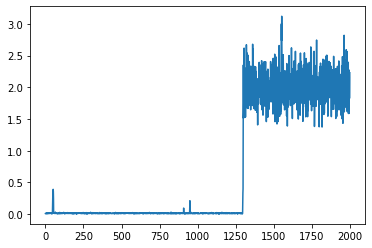

In [18]:
plt.plot(l)

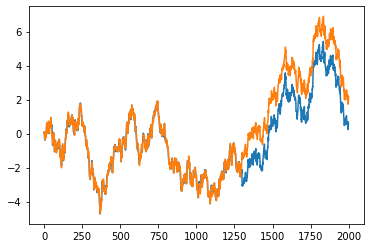

In [19]:
plt.plot(-theta)
plt.plot(pn[::20])

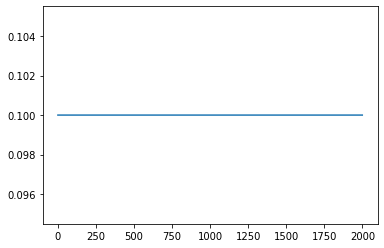

In [25]:
plt.plot(jax.nn.sigmoid(history['params']['eta']))

## DDLMS

In [45]:
import commplax.adaptive_filter as af
from commplax.module.core import Signal, SigTime, dict_replace
from optical_flax.layers import mimoaf
from functools import partial
config.update("jax_enable_x64", False)
init, update, apply = af.ddlms(train=True)
ys = Signal(y, t=SigTime(0,0,1))

In [79]:
net = mimoaf(taps=3,sps=1, mimofn=partial(af.ddlms, lr_w=0.01, lr_f=0.01, lr_b=0.01))
state = net.init(rd.PRNGKey(0), ys)
# state = dict_replace(state, {'truth':truth})

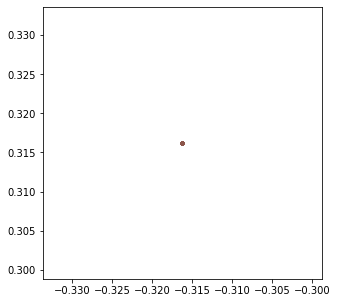

In [80]:
y1,s1 = net.apply(state, ys, mutable={'af_state'})
plt.figure(figsize=(5,5))
show_symb(y1.val,truth[1:-1,0])

In [27]:
import flax.linen as nn
class DDPLL(nn.Module):
    @nn.compact
    def __call__(self, signal):
        x,t = 

(3996,)

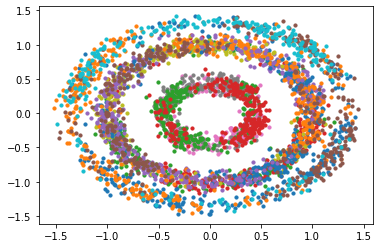

In [38]:
show_symb(y[:,0],truth[:,0])